# Initial Imports

In [1]:
%matplotlib inline

import os
import json
import time
import pickle
import requests
import math


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Load Data From .csv

In [2]:
df = pd.read_csv('may_june_july.csv', delimiter="|")

## Data Formatting

In [3]:
# Combine all text 
df['tags'] = df['descr'] + " " + df["title"] + " " + df["cat"]+ " " + df["primary_kw"]+ " " + df["tags"] 
# Drop unneeded columns
df.drop('id', axis=1, inplace=True)
df.drop('pull_cc', axis=1, inplace=True)
df.drop('cc', axis=1, inplace=True)
df.drop('metav', axis=1, inplace=True)
df.drop('descr', axis=1, inplace=True)
df.drop('title', axis=1, inplace=True)
df.drop('primary_kw', axis=1, inplace=True)
df.drop('cat', axis=1, inplace=True)

In [4]:
df.head()

,freq,impressions,tags
0,2,29316,Giant man with tiny dog alert! The Mountain Fr...
1,2,17180,FYI: Ice cream sandwiches &gt; all other sandw...
2,2,3474,"""My mama always said you can tell a lot about ..."
3,2,9027,Let's see if you're a true cheese whiz. Can Yo...
4,2,7247,The EPA just released first-time guidelines on...


## Compute Heuristic Measurement

In [5]:
# NORMALIZE TO LOG DISTRIBUTION
# Compute Log (freq*impressions/1000)
# Add log column
df['Log'] = df['freq']*df['impressions']

for i, row in df.iterrows():
    cv = math.log(df.iloc[i,3],2)
    df.set_value(i,'Log',cv)

# Drop unneeded column
df.drop('freq', axis=1, inplace=True)
df.drop('impressions', axis=1, inplace=True)
df.head()

,tags,Log
0,Giant man with tiny dog alert! The Mountain Fr...,15
1,FYI: Ice cream sandwiches &gt; all other sandw...,15
2,"""My mama always said you can tell a lot about ...",12
3,Let's see if you're a true cheese whiz. Can Yo...,14
4,The EPA just released first-time guidelines on...,13


In [6]:
data_mean = df["Log"].mean()
data_mean

19.444149122193465

In [7]:
data_std = df["Log"].std()
data_std

3.2282119418494077

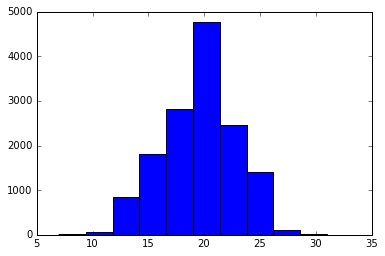

In [8]:
plt.hist(df["Log"])
plt.show()

In [9]:
# Virality defined as -1 sigma from mean
df['viral'] = np.where(df['Log']<data_mean-data_std, 'notviral', 'viral')
df['viral_num'] = df.viral.map({'notviral':0, 'viral':1})
df.drop('Log', axis=1, inplace=True)
df.head()

,tags,viral,viral_num
0,Giant man with tiny dog alert! The Mountain Fr...,notviral,0
1,FYI: Ice cream sandwiches &gt; all other sandw...,notviral,0
2,"""My mama always said you can tell a lot about ...",notviral,0
3,Let's see if you're a true cheese whiz. Can Yo...,notviral,0
4,The EPA just released first-time guidelines on...,notviral,0


In [10]:
df['tags'].fillna('a', inplace=True)

In [11]:
df.tail()

,tags,viral,viral_num
14292,A former Stanford swimmer who sexually assault...,viral,1
14293,A former Stanford swimmer who sexually assault...,viral,1
14294,A former Stanford swimmer who sexually assault...,viral,1
14295,A definitive ranking of our dirtiest words. Th...,viral,1
14296,"Don't worry, you won't need to know Chandler B...",viral,1


In [12]:
df.shape

(14297, 3)

In [13]:
df.viral.value_counts()

viral       11564
notviral     2733
Name: viral, dtype: int64

In [14]:
X = df.tags
y = df.viral_num
print(X.shape)
print(y.shape)

(14297,)
(14297,)


In [15]:
X.head()

0    Giant man with tiny dog alert! The Mountain Fr...
1    FYI: Ice cream sandwiches &gt; all other sandw...
2    "My mama always said you can tell a lot about ...
3    Let's see if you're a true cheese whiz. Can Yo...
4    The EPA just released first-time guidelines on...
Name: tags, dtype: object

In [16]:
y.head()

0    0
1    0
2    0
3    0
4    0
Name: viral_num, dtype: int64

# Split Data into Train & Test Sets

In [17]:
# Sci-Kit Learn Imports
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

In [18]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(10722,)
(3575,)
(10722,)
(3575,)


# Vectorize Text Values

In [19]:
from sklearn.feature_extraction.text import CountVectorizer

vect = CountVectorizer()

In [20]:
vect

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [21]:
# learn training data vocabulary, then use it to create a document-term matrix

X_train_dtm = vect.fit_transform(X_train)

In [22]:
# transform testing data (using fitted vocabulary) into a document-term matrix
X_test_dtm = vect.transform(X_test)
X_test_dtm

<3575x15480 sparse matrix of type '<class 'numpy.int64'>'
	with 87915 stored elements in Compressed Sparse Row format>

## (What's going on under the hood?)

In [23]:
demo_vect = CountVectorizer()

corpus = [
    'This is a unique BuzzFeed article title.',
    'A second less unique BuzzFeed article title.',
    'And a third.',
    'Is this a unique BuzzFeed article title?',
]

X = demo_vect.fit_transform(corpus)
X.toarray()

array([[0, 1, 1, 1, 0, 0, 0, 1, 1, 1],
       [0, 1, 1, 0, 1, 1, 0, 0, 1, 1],
       [1, 0, 0, 0, 0, 0, 1, 0, 0, 0],
       [0, 1, 1, 1, 0, 0, 0, 1, 1, 1]], dtype=int64)

In [24]:
X_train_tokens = vect.get_feature_names()
X_train_tokens[1200:1215]

['ban',
 'banana',
 'bananas',
 'band',
 'bandicoot',
 'bandra',
 'bands',
 'banega',
 'banerjee',
 'banff',
 'banfield',
 'bang',
 'banga',
 'bangalore',
 'bangla']

In [25]:
len(X_train_tokens)

15480

# Modeling

## Naive Bayes

In [26]:
# import and instantiate a Multinomial Naive Bayes model
from sklearn.naive_bayes import MultinomialNB

nb = MultinomialNB()

In [27]:
# train the model using X_train_dtm (timing it with an IPython "magic command")
%time nb.fit(X_train_dtm, y_train)

CPU times: user 6.61 ms, sys: 1.55 ms, total: 8.16 ms
Wall time: 7.45 ms


MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [28]:
# make class predictions for X_test_dtm
y_pred_class = nb.predict(X_test_dtm)

In [29]:
# calculate accuracy of class predictions
from sklearn import metrics
metrics.accuracy_score(y_test, y_pred_class)

0.78965034965034964

In [30]:
# some false positive examples (non-viral incorrectly classified as viral)
X_test[y_test < y_pred_class].head()

2356    So much fierce, so little time. Here's What A ...
4046    Robert Czegely has been accused of "gross misc...
3116    Put your JT fandom to the test. Are These Nsyn...
1094    Hold the door. 53 Thoughts I Had Watching Seas...
1312    Identify them all! Can You Guess The Pok mon B...
Name: tags, dtype: object

In [31]:
# some false negative examples (Viral incorrectly classified as non-viral)
X_test[y_test > y_pred_class].head()

7120     "You spent some time away..." Brace Yourselves...
11141    Mmmmmmmmmmmmmmmm. 16 Extremely Satisfying Pict...
12571    It wasn't. 17 Things That Will Make Every Indi...
5558     "You're worthy of the last French fry in the b...
10655    Worse still, literally no one is surprised. De...
Name: tags, dtype: object

## Logistic Regression

In [32]:
# import and instantiate a logistic regression model
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression()

In [33]:
# train the model using X_train_dtm
%time logreg.fit(X_train_dtm, y_train)

CPU times: user 367 ms, sys: 5.86 ms, total: 373 ms
Wall time: 376 ms


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [34]:
# make class predictions for X_test_dtm
y_pred_class = logreg.predict(X_test_dtm)

In [35]:
# calculate accuracy
metrics.accuracy_score(y_test, y_pred_class)

0.80083916083916085